# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


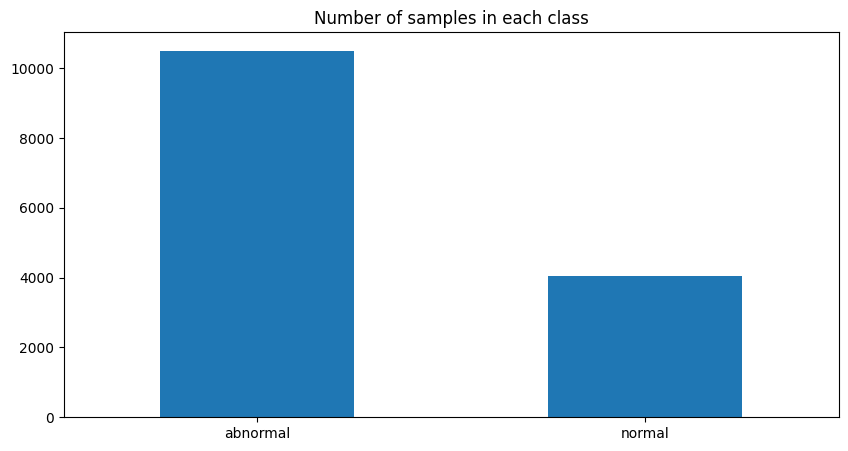

In [7]:
df_ptbd_normal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

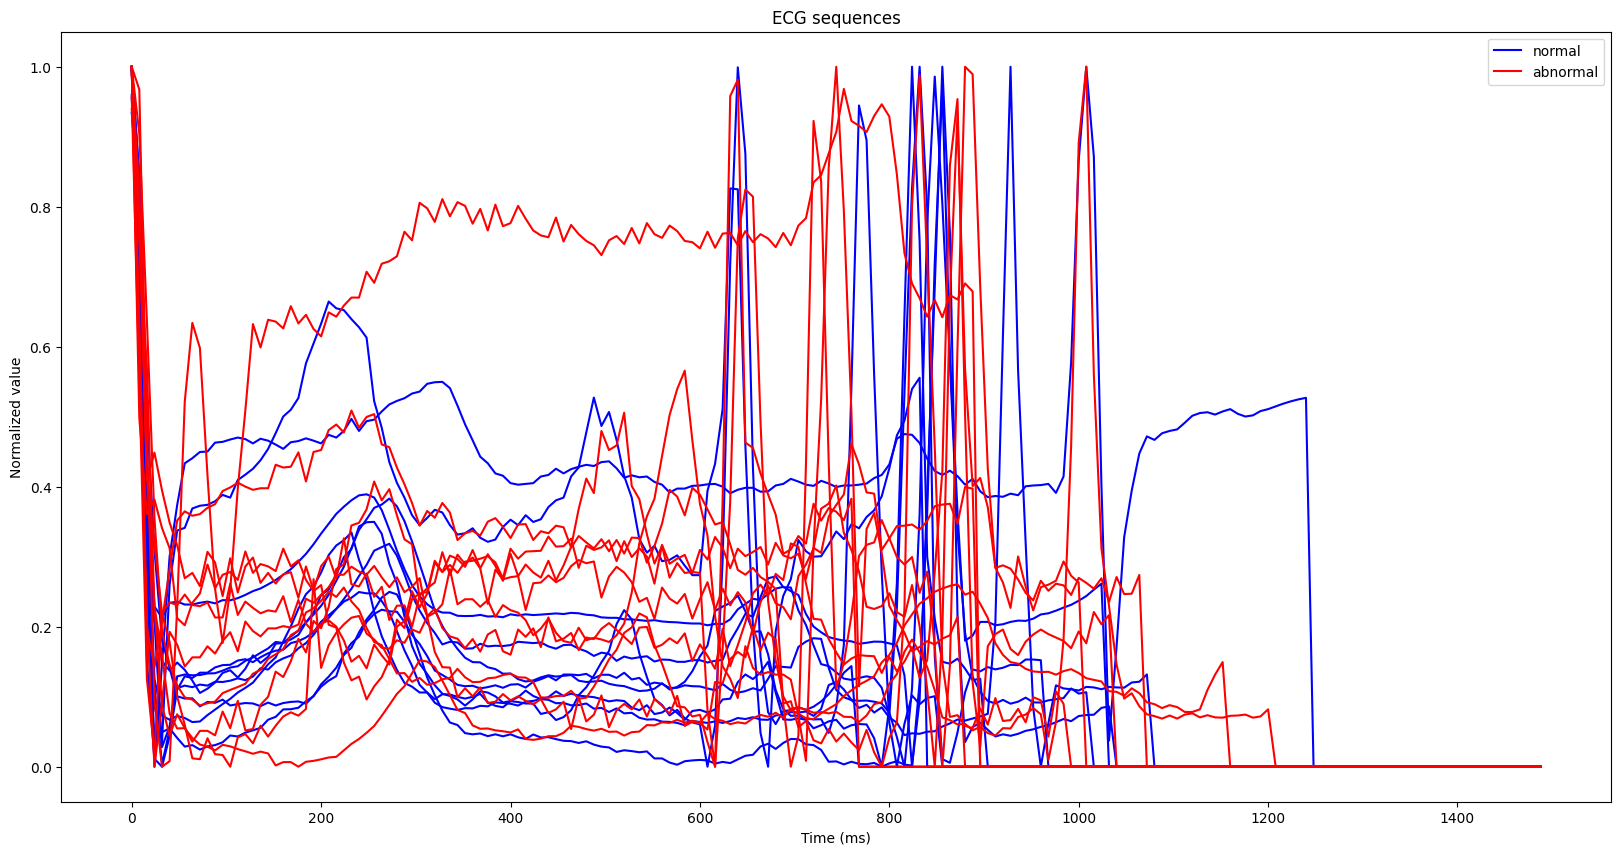

In [8]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [11]:
'''PREVIOUS ATTEMPT DOES NOT WORK PROPERLY'''
# gathering data from df
# data is organized s.t. we have up to col idx 187 of y values for each time stamp
# val in cold idx 188 is the class of set
X_val = df_ptbd.iloc[:, :187].values
X_val = torch.from_numpy(X_val)
y_val = df_ptbd.iloc[:, 187].values
y_val = torch.from_numpy(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], -1))


# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

cat_outputs = []
for layer in range(10): # 5 layers
  rf = RandomForestClassifier(n_estimators=140) # define random forest model
  rf.fit(X_train, y_train) # training model
  layer_out = rf.predict(X_train) # make some predictions
  layer_out = torch.from_numpy(layer_out) # torch.cat expects a tensor
  layer_out = layer_out.unsqueeze(0) # reshape to match X_train by adding new axis
  print(layer_out.shape, X_train.shape, X_test.shape)

  y_pred = rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred) # evaluating model
  print(acc)

  cat_outputs.append(layer_out)

X_train = torch.cat(cat_outputs, dim=0)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred) # evaluating model

print(acc)

torch.Size([11641, 187]) torch.Size([11641])
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9721745104774991
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9732050841635177
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.971830985915493
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9721745104774991
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.971830985915493
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9728615596015115
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9725180350395053
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.9725180350395053
torch.Size([1, 11641]) torch.Size([11641, 187]) torch.Size([2911, 187])
0.971830985915493


KeyboardInterrupt: ignored

In [10]:
# gathering data from df
# data is organized s.t. we have up to col idx 187 of y values for each time stamp
# val in cold idx 188 is the class of set
X_val = df_ptbd.iloc[:, :187].values
X_val = torch.from_numpy(X_val)
y_val = df_ptbd.iloc[:, 187].values
y_val = torch.from_numpy(y_val)
# rehsape array to same num of rows, and automatically calculated columns
X_val = np.reshape(X_val, (X_val.shape[0], -1)) # ensures correct dimensions
print(X_val.shape)

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

rf = RandomForestClassifier(n_estimators=100) # define the random forest model for use in DeepForest
rf.fit(X_train, y_train) # train random forest
leaf_indices = rf.apply(X_train) # extract indices of leaf nodes to use as training data for deep forest
num_leaf_nodes = np.max(leaf_indices) + 1 # number of unique lead node indicies

torch.Size([14552, 187])
torch.Size([11641, 187]) torch.Size([11641])


In [11]:
# one hot encode leaf node values
# one hot encoding is a binary representation of categorical variables used to represenet leaf node indices
# this converts discrete leaf node indices into a continous feature representation of each sample
# these encodings (feature representations) are fed to the networks laryers,
# allowing it to better understand more complex patterns between node indices and target variables
# effectively combining advantages of random forests and deep learning
leaf_encodings = torch.zeros(len(leaf_indices), len(rf.estimators_), num_leaf_nodes)
for i, idxs in enumerate(leaf_indices):
  leaf_encodings[i] = torch.nn.functional.one_hot(torch.tensor(idxs), num_classes=num_leaf_nodes)



In [12]:

class DeepForest(nn.Module):
  def __init__(self, input_size):
    super(DeepForest, self).__init__()
    # size is number of leaf nodes * number of trees in each random forest
    self.fc1 = nn.Linear(input_size * len(rf.estimators_), 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

  def forward(self, x): # recall x is the one hot encs of lead node indices
    x = x.view(x.size(0), -1) # reshape x to 2D where dim[0] is batch size, and dim[1] auto calculated
    x = torch.relu(self.fc1(x)) # transform using learned weights and biases
    x = torch.relu(self.fc2(x))
    x = self.fc3(x) # output layer gives the models classification
    return x


In [16]:
# Initialize the Deep Forest model
print(leaf_encodings.shape, y_train.shape)
deep_forest_model = DeepForest(input_size=num_leaf_nodes)

# Define the loss function and optimizer
# binary cross entropy w/ logitsloss
# using with logits since we have raw output values of model inbetween random forest layers
# automatically applies sigmoid functions to predcted output before loss calculation
# loss computed by comparing predicted output (post sigmoid) with target labels
# loss indicated guides model to adjust parameters through back prop and grad desc
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deep_forest_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
leaf_encodings_train = torch.Tensor(leaf_encodings)
y_train = torch.Tensor(y_train)

# Train the Deep Forest model
num_epochs = 5
batch_size = 32
num_batches = len(leaf_encodings_train) // batch_size

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        optimizer.zero_grad() # zero out gradients of params before backward pass

        # slice batch properly
        batch_x = leaf_encodings_train[start_idx:end_idx]
        batch_y = y_train[start_idx:end_idx].view(-1,1) # Adjust dimension

        outputs = deep_forest_model(batch_x) # give batch to deep forest model
        loss = criterion(outputs, batch_y) # compute loss

        loss.backward() # compute gradients with back prop
        optimizer.step() # update model parameters based on computer gradients

        epoch_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss/num_batches))



torch.Size([11641, 100, 1189]) torch.Size([11641])
Epoch [1/5], Loss: 0.0314
Epoch [2/5], Loss: 0.0001
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


In [17]:
with torch.no_grad():
    leaf_indices_test = rf.apply(X_test)
    leaf_encodings_test = torch.zeros((len(leaf_indices_test), len(rf.estimators_), num_leaf_nodes))
    for i, indices in enumerate(leaf_indices_test):
        leaf_encodings_test[i] = torch.nn.functional.one_hot(torch.tensor(indices), num_classes=num_leaf_nodes)

    leaf_encodings_test = torch.Tensor(leaf_encodings_test)
    y_pred = deep_forest_model(leaf_encodings_test)
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()

    accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy: {:.4f}'.format(accuracy))

Test Accuracy: 0.9811


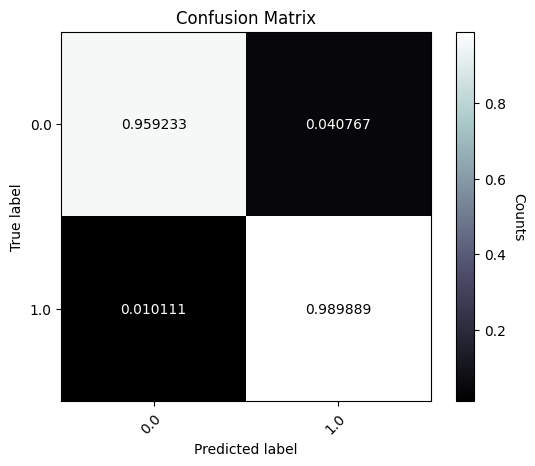

In [18]:
cm = confusion_matrix(y_test, y_pred)
row_sums = cm.sum(axis=1)
cm = cm / row_sums[:, np.newaxis]
labels = unique_labels(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.bone)
colorbar = ax.figure.colorbar(im, ax=ax)
colorbar.ax.set_ylabel('Counts', rotation=-90, va='bottom')

# Set the tick marks and labels
tick_marks = np.arange(len(labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Set the axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = 0.25
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'f'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "white")

ax.set_title('Confusion Matrix')
plt.show()